In [1]:
import numpy as np

import qutip as qtip

from tqdm  import tqdm

import matplotlib.pyplot as plt


In [2]:
def find_m(Δ, Ω, offset=0):
    return np.rint( (Δ+offset)/Ω)

# @jit
def find_ss_approx(params, offset=0):
    κ, κ_ϕ, Δ, F, χ = params
    H = Δ* a.dag()*a  + χ * a.dag()*a.dag()*a*a + F*(a.dag()+a)
    
    # c_ops = [np.sqrt(κ)*a, np.sqrt(κ_ϕ)*a.dag()*a]
    c_ops = [np.sqrt(κ)*a, np.sqrt(κ_ϕ)*a.dag()*a]

    return qtip.steadystate(H, c_ops)

def find_num_approx(params, offset=0):
    ss = find_ss_approx(params, offset)
    return qtip.expect(ss, a.dag()*a)

def find_a_approx(params, offset=0):
    ss = find_ss_approx(params, offset)
    return qtip.expect(ss, a)

def find_num_S21_a(params, kappa_c, offset=0, coupling='notch'):
    ss = find_ss_approx(params, offset)
    num = qtip.expect(ss, a.dag()*a)
    a_exp = qtip.expect(ss, a)
    κ,κ_ϕ, Δ, F, χ = params
    
    if coupling == 'notch':
        S21 = 1 - 1j*kappa_c/2 * a_exp / F
    elif coupling == 'reflection':
        S21 = 1 - 1j*kappa_c * a_exp / F

    return num, a_exp, S21

# Reflection tmon simu

**1D cut**

In [15]:
coupling = 'reflection'

Chi = 200
kappa_ext = 10
kappa_int = 1
kappa_tot = kappa_ext + kappa_int
kappa_phi = 0

F = abs(Chi*0.002)

N_cutoff = 5
a = qtip.destroy(N_cutoff)

Delta_list = np.arange(-50, 50, 0.1)

S21_list = []
for Delta in tqdm(Delta_list):
    params = [kappa_tot, kappa_phi, Delta, F, Chi]
    num, a_exp, S21 = find_num_S21_a(params, kappa_ext, coupling=coupling)
    S21_list.append(S21)
    
S21_list = np.array(S21_list)

100%|██████████| 1000/1000 [00:00<00:00, 3241.38it/s]


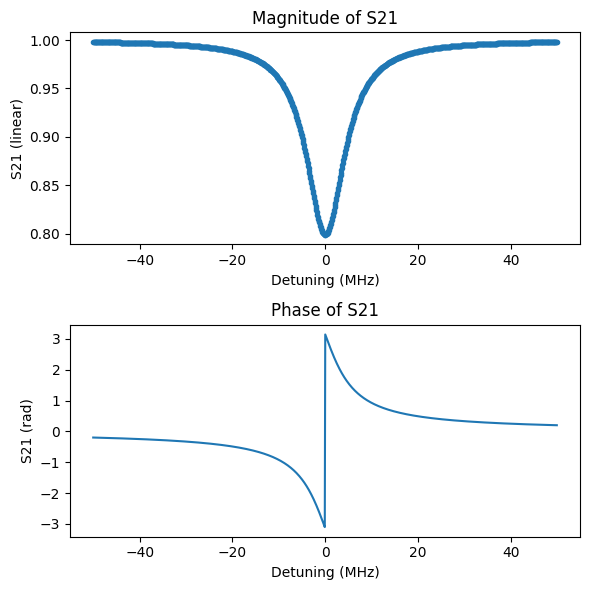

In [16]:
## 2 nrows subplots with mag and phas eof S21. MAg in dB.

fig, axs = plt.subplots(2, 1, figsize=(6, 6))

ax=axs[0]
# ax.plot(Delta_list, 20*np.log10(np.abs(S21_list)))
ax.plot(Delta_list, (np.abs(S21_list)), '.-')
ax.set_ylabel('S21 (linear)')
ax.set_xlabel('Detuning (MHz)')
ax.set_title('Magnitude of S21')

ax=axs[1]
ax.plot(Delta_list, np.angle(S21_list))
ax.set_ylabel('S21 (rad)')
ax.set_xlabel('Detuning (MHz)')
ax.set_title('Phase of S21')

plt.tight_layout()
plt.show()


**2D cut**

In [5]:
coupling = 'reflection'

Chi = 200
kappa_ext = 20
kappa_int = 1
kappa_tot = kappa_ext + kappa_int
kappa_phi = 0

F = Chi*0.1

F_list = abs(np.geomspace(0.01, 0.5, 15)*Chi)

N_cutoff = 5
a = qtip.destroy(N_cutoff)

Delta_list = np.arange(-300, 50, 0.5)

S21_list = []

for F in tqdm(F_list):
    S21_list_temp = []
    for Delta in Delta_list:
        params = [kappa_tot, kappa_phi, Delta, F, Chi]
        num, a_exp, S21 = find_num_S21_a(params, kappa_ext, coupling=coupling)
        S21_list_temp.append(S21)
    S21_list.append(S21_list_temp)

S21_list = np.array(S21_list)

100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


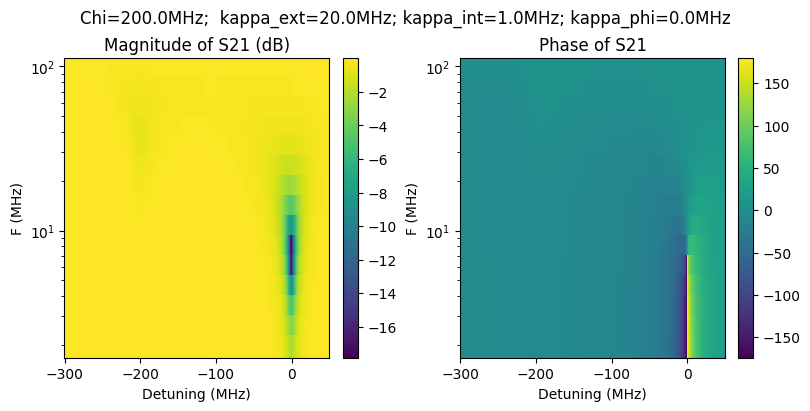

In [6]:
##2D pcolormesh plot of S21. 2 ncols here: one linear mag, one phase in deg

fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
fig.suptitle(f'Chi={Chi:.1f}MHz;  kappa_ext={kappa_ext:.1f}MHz; kappa_int={kappa_int:.1f}MHz; kappa_phi={kappa_phi:.1f}MHz')

ax=axs[0]
pcm = ax.pcolormesh(Delta_list, F_list, 20*np.log10(np.abs(S21_list)))
fig.colorbar(pcm, ax=ax)
ax.set_ylabel('F (MHz)')
ax.set_xlabel('Detuning (MHz)')
ax.set_title('Magnitude of S21 (dB)')
ax.set_yscale('log')

ax=axs[1]
pcm = ax.pcolormesh(Delta_list, F_list, np.angle(S21_list)*180/np.pi)
fig.colorbar(pcm, ax=ax)
ax.set_ylabel('F (MHz)')
ax.set_xlabel('Detuning (MHz)')
ax.set_title('Phase of S21')
ax.set_yscale('log')

plt.show()